In [198]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from iobs.layers import IOBLayer
from iobs.models import BaseAE
from torch import nn, optim
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [199]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

In [200]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [201]:
# directories = [
#     "noiseless_1000_simple_narrow",
#     "noiseless_1000_simple_broad",
#     "noiseless_1000_simple_middle",
#     "noiseless_1000_simple_broad_narrow_time",
#     "noiseless_1000_scattered",
#     "noiseless_1000_complex",
#     "noiseless_1000_drifting",
# ]

# Define the directories containing the data for different classes
directories = [
    "1000_Constant_SNR_simple_narrow",
    "1000_Constant_SNR_simple_broad",
    "1000_Constant_SNR_simulated_scattered",
    "1000_Constant_SNR_complex",
    "1000_Constant_SNR_drifting",
]

# Define the directories containing the data for different classes
# directories = [
#     "1000_Constant_SNR_simple_narrow_res",
#     "1000_Constant_SNR_simple_broad_res",
#     "1000_Constant_SNR_simulated_scattered_res",
#     "1000_Constant_SNR_complex_res",
#     "1000_Constant_SNR_drifting_res",
# ]


# Initialize lists to store data and corresponding labels
data = []
labels = []

# Iterate over each class directory
for class_idx, directory in enumerate(directories):
    # Construct the full path to the data directory
    data_dir = f"data/{directory}"
    data_per_directory = []

    # Iterate over each file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            # Load the dynamic spectra with pulse from the file
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            
            # Rebin the spectrum to a smaller size
            rebinned_spectrum = rebin(dynamic_spectra_w_pulse, (int(1024/4), int(512/4)))
            
            # Ensure no zero values in the rebinned spectrum to avoid issues during processing
            if np.any(rebinned_spectrum == 0.0):
                rebinned_spectrum[rebinned_spectrum == 0] = 0.0001
            
            # Append the rebinned spectrum to the list of data for this class
            data_per_directory.append(rebinned_spectrum)
            
            # Append the class index as the label for this data point
            labels.append(class_idx)

    # Limit the number of data points per class
    data_per_directory = np.array(data_per_directory)[:1000]
    
    # Append the data for this class to the overall data list
    data.append(data_per_directory)

# Concatenate the data and labels for all classes
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)


In [202]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Prep data for Network

In [203]:
# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Convert labels to PyTorch tensors
labels_train_tensor = torch.LongTensor(labels_train)
labels_test_tensor = torch.LongTensor(labels_test)

# Create weights for training data
train_weights = np.zeros_like(data_train_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_train_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    train_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
train_weights_tensor = torch.tensor(train_weights)

# Create weights for test data
test_weights = np.zeros_like(data_test_tensor)

# Calculate the minimum absolute value for every spectrum and add it to the weights list
for i, spectra in enumerate(data_test_tensor):
    min_abs_value = torch.min(torch.abs(spectra))
    test_weights[i, :, :, :]=(torch.log((torch.abs(spectra) / min_abs_value.item())) + 0.1)

# Convert weights to pytorch tensor
test_weights_tensor = torch.tensor(test_weights)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, train_weights_tensor, labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor, test_weights_tensor, labels_test_tensor)

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define my own Loss Function to give more importance to signal

In [204]:
# Define weighted loss function to give more strength to signal
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets, weights):
        return torch.sum(((inputs - targets) ** 2 ) * weights)

## Information Ordered Bottleneck

In [205]:
class BaseAE_noUnflatt(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 bottleneck: IOBLayer
                 ) -> None:
        """Basic autoencoder model with support for IOB forward functions

        Args:
            encoder (nn.Module): An encoder module which outputs a dense layer
            decoder (nn.Module): A decoder module which accepts a dense layer
            bottleneck (nn.Module): An IOBLayer module
        """
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.bottleneck = bottleneck
        self.latent_dim = bottleneck.num_features

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """Usual forward autoencoding with a fully-open bottleneck."""
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_mask(self, features: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """Apply a custom mask to the latent vector. Mask must be of shape
        (self.latent_dim) or (batch_size, self.latent_dim).
        """
        code = self.encoder(features)
        code = self.bottleneck.forward_mask(code, mask)
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_neck(self, features: torch.Tensor, n_open: int) -> torch.Tensor:
        """Forward autoencoding with a bottleneck of width n_open."""
        code = self.encoder(features)
        code = self.bottleneck.forward_neck(code, n_open)
        reconstructed = self.decoder(code)
        return reconstructed

    def forward_all(self, features: torch.Tensor) -> torch.Tensor:
        """Pass through the batch for all possible bottleneck widths.
        Creates a new axis in the output batch to store different bottleneck
        configurations. For example, if the input is of shape
        (batch_size, *in_shape), then this function will output a Tensor
        of shape (batch_size, self.latent_dim+1, *in_shape), where the first
        index of the second axis is equivalent to n_open=0 and the last
        index is equivalent to n_open=num_features.
        """
        batch_size = len(features)
        code = self.encoder(features)
        
        ## shape  = bathc_size, dim+1 , dim
        code = self.bottleneck.forward_all(code)
        #print(code.shape)
        
        ## This originally collapse  batch_size * dim+1
        #code = torch.flatten(code, end_dim=1)
        code = code.view(code.size(0)*code.size(1), code.size(2))
        #print(code.shape)
        reconstructed = self.decoder(code)
        
        ## This will go back to batchsize, dim+1, n_filters, outsize outsize
#         reconstructed = torch.unflatten(
#             reconstructed, dim=0, sizes=(batch_size, -1))
        
        reconstructed = reconstructed.view(batch_size,self.latent_dim+1,*features.shape[1:])
        #print(reconstructed.shape)
        return reconstructed

In [206]:
def build_dense_sequence(shape_list):
    """Convenience function for building a sequence of dense (Linear) layers"""
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

# define a fully-connected encoder
encoder = nn.Sequential(
    *(build_dense_sequence([256*128, 1000, 100, 25])),
).to(device)

# define a fully-connected decoder
decoder = nn.Sequential(
    *(build_dense_sequence([25, 100, 1000, 256*128])),
).to(device)

# define a IOB with a max width of 4 features
bottleneck = IOBLayer(25, device=device)

# Initialize the autoencoder
model = BaseAE_noUnflatt(
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
).to(device)

# Define weighted loss function to give more strength to signal
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets, weights):
        return torch.sum(((inputs - targets) ** 2 ) * weights)

# Define the loss function and optimizer
# criterion = weighted_MSELoss()
criterion = nn.MSELoss()

def lossfn(model, data):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs_list = model.forward_all(data)
    # print(outputs_list.shape)
    target = data.unsqueeze(1).expand(*(outputs_list.shape))
    # print(target.shape)
    loss = criterion(outputs_list, target)
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.0005)

## Train the network

In [207]:
num_epochs = 1000

best_loss = float('inf')
patience = 50
counter = 0

for epoch in range(num_epochs):
    for data, weights, _ in train_loader:
        inputs = data.to(device).reshape(-1, 128*256)
        outputs = model(inputs)
        batch_loss = lossfn(model, inputs)
    
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    if epoch % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {batch_loss.item():.6f}')
    
    # Calculate average epoch loss
    epoch_loss = batch_loss / len(train_loader.dataset)
    
    # Check for early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0  # Reset counter if loss improves
    else:
        counter += 1  # Increment counter if loss doesn't improve

    if counter >= patience:
        print("Early stopping: Loss has not improved for {} epochs.".format(patience))
        break

Epoch [1/1000], Loss: 0.001072
Epoch [21/1000], Loss: 0.000578
Epoch [41/1000], Loss: 0.000518
Epoch [61/1000], Loss: 0.000483
Epoch [81/1000], Loss: 0.000455
Epoch [101/1000], Loss: 0.000389
Epoch [121/1000], Loss: 0.000412
Epoch [141/1000], Loss: 0.000512
Epoch [161/1000], Loss: 0.000490
Early stopping: Loss has not improved for 50 epochs.


## Visualize reconstruction

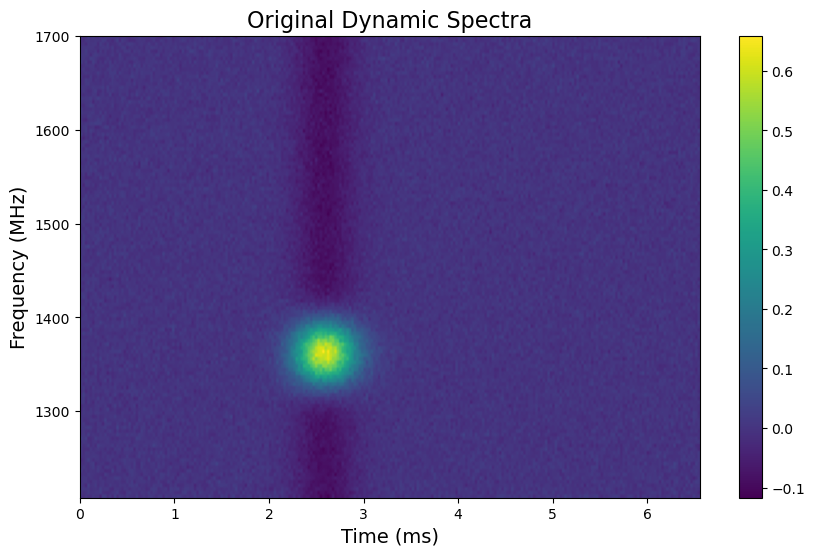

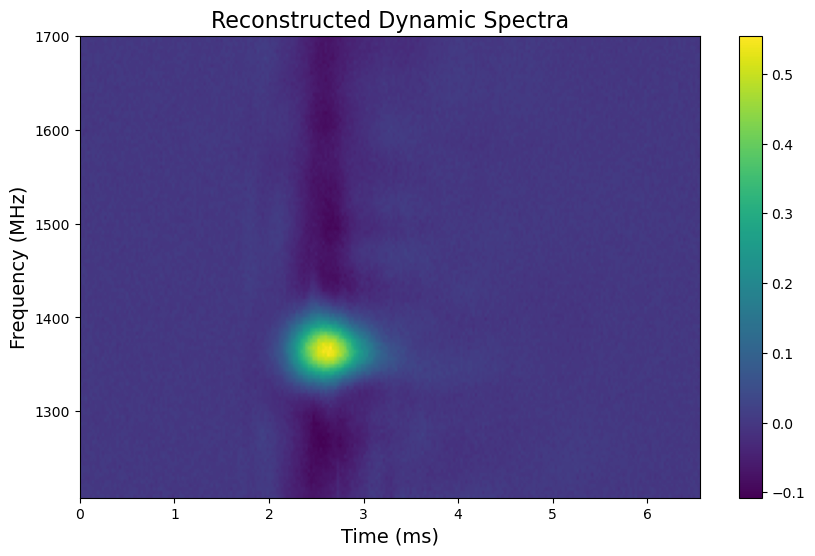

In [193]:
# Testing the autoencoder
model.eval()
with torch.no_grad():
    inputs = data_test_tensor.reshape(-1, 128*256).to(device)  # Move input data to the GPU
    reconstructed = model(inputs)
    
idx = 300

# Convert tensors to numpy arrays for plotting
original_np = inputs[idx].cpu().numpy().reshape((int(1024/4), int(512/4)))  # Move data back to CPU for plotting
reconstructed_np = reconstructed[idx].cpu().numpy().reshape((int(1024/4), int(512/4)))  # Move data back to CPU for plotting

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")

## Look at Reconstruction Error as function of Bottleneck width

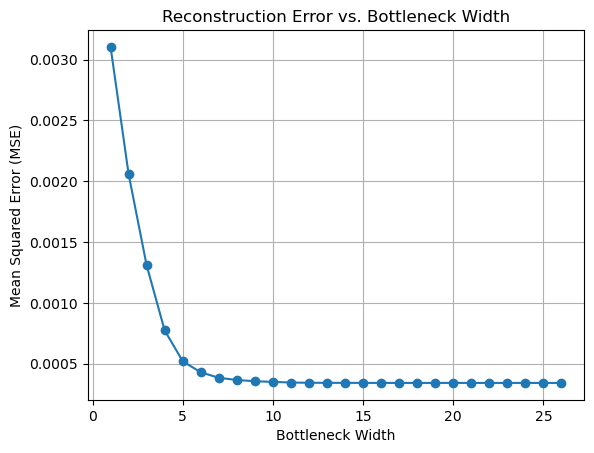

In [208]:
# Initialize lists to store reconstruction errors and bottleneck sizes
reconstruction_errors = []
bottleneck_sizes = []

# Testing the autoencoder batch-wise
model.eval()
reconstructed_all = []

with torch.no_grad():
    for batch_features, _, _ in test_loader:
        batch_features = batch_features.to(device).reshape(-1, 128 * 256)  # Move input data to the GPU and reshape
        reconstructed_batch = model.forward_all(batch_features).detach().cpu().numpy()  # Forward the batch through the model
        reconstructed_all.append(reconstructed_batch)

# Concatenate reconstructed batches
reconstructed_all = np.concatenate(reconstructed_all, axis=0)

# Iterate over possible bottleneck widths
for width in range(model.latent_dim + 1):
    # Select reconstructed data for the current bottleneck width
    reconstructed = reconstructed_all[:, width]
    
    # Calculate Mean Squared Error (MSE) for the current bottleneck width
    mse = mean_squared_error(data_test.flatten(), reconstructed.flatten())
    
    # Store reconstruction error (MSE) and bottleneck size
    reconstruction_errors.append(mse)
    bottleneck_sizes.append(width + 1) # Smallest Latent Space is 1

# Plot the reconstruction error (MSE) vs. bottleneck width
plt.plot(bottleneck_sizes, reconstruction_errors, marker='o')
plt.xlabel('Bottleneck Width')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Bottleneck Width')
plt.grid(True)
plt.show()



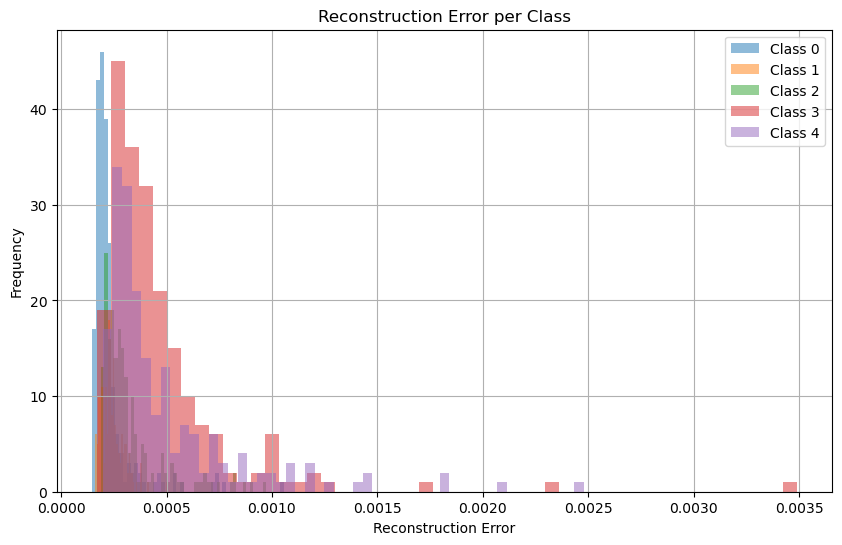

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming num_classes is defined
num_classes = len(np.unique(labels_test))

# Initialize lists to store the reconstruction error per class
reconstruction_errors_per_class = [[] for _ in range(num_classes)]

# Evaluate the autoencoder
model.eval()
with torch.no_grad():
    # Move input data to the GPU
    inputs = data_test_tensor.reshape(-1, 128*256).to(device)  
    
    # Forward pass through the model
    reconstructed = model(inputs)
    
    # Move the reconstructed data to CPU and convert it to a NumPy array
    reconstructed = reconstructed.cpu().numpy()

# Calculate the reconstruction error per class
for class_idx in range(num_classes):
    # Get indices of data points belonging to the current class
    class_indices = np.where(labels_test == class_idx)[0]
    
    # Calculate the reconstruction error for data points of the current class
    for idx in class_indices:
        error = np.mean(np.square(inputs[idx].cpu().numpy() - reconstructed[idx]))
        reconstruction_errors_per_class[class_idx].append(error)

# Plot the reconstruction error per class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.hist(reconstruction_errors_per_class[class_idx], bins=50, alpha=0.5, label=f'Class {class_idx}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error per Class')
plt.legend()
plt.grid(True)
plt.show()


## Look at Reconstruction Error as a function of Bottleneck size including Different Classes

In [194]:
# Initialize lists to store reconstruction errors per label and bottleneck sizes
reconstruction_errors_per_label = {label: [] for label in set(labels_test)}
reconstruction_errors = []
bottleneck_sizes = []

# Testing the autoencoder batch-wise
model.eval()
reconstructed_all = []

with torch.no_grad():
    for batch_data, _, batch_labels in test_loader:  # Extract only batch_data and batch_labels
        batch_data = batch_data.to(device).reshape(-1, 128 * 256)  # Move input data to the GPU and reshape
        reconstructed_batch = model.forward_all(batch_data).detach().cpu().numpy()  # Forward the batch through the model
        reconstructed_all.append(reconstructed_batch)

# Concatenate reconstructed batches
reconstructed_all = np.concatenate(reconstructed_all, axis=0)

# Iterate over possible bottleneck widths
for width in range(model.latent_dim + 1):
    # Select reconstructed data for the current bottleneck width
    reconstructed = reconstructed_all[:, width]
    
    # Calculate Mean Squared Error (MSE) for the current bottleneck width
    mse = mean_squared_error(data_test.flatten(), reconstructed.flatten())
    
    # Store reconstruction error (MSE) and bottleneck size
    reconstruction_errors.append(mse)

# Iterate over possible bottleneck widths
for width in range(model.latent_dim + 1):
    # Iterate over each label
    for label in set(labels_test):
        # Select reconstructed data for the current bottleneck width and label
        reconstructed = reconstructed_all[labels_test == label, width]

        # Calculate Mean Squared Error (MSE) for the current bottleneck width and label
        mse = mean_squared_error(data_test[labels_test == label].flatten(), reconstructed.flatten())

        # Store reconstruction error (MSE) for the current label and bottleneck size
        reconstruction_errors_per_label[label].append(mse)

    # Store bottleneck size
    bottleneck_sizes.append(width + 1)  # Smallest Latent Space is 1

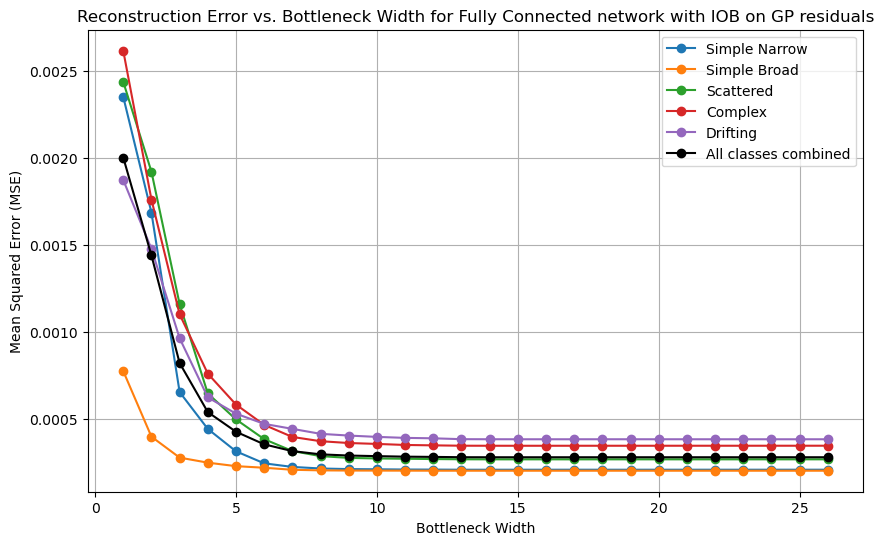

In [196]:
# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Plot the reconstruction error (MSE) vs. bottleneck width for each label
plt.figure(figsize=(10, 6))
for idx, (label, errors) in enumerate(reconstruction_errors_per_label.items()):
    plt.plot(bottleneck_sizes, errors, marker='o', label=f'{burst_labels[label]}')

plt.plot(bottleneck_sizes, reconstruction_errors, marker='o', color='black', label='All classes combined')

plt.xlabel('Bottleneck Width')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Bottleneck Width for Fully Connected network with IOB on GP residuals')
plt.legend()
plt.grid(True)
plt.show()

## Look at reconstructions for different widths

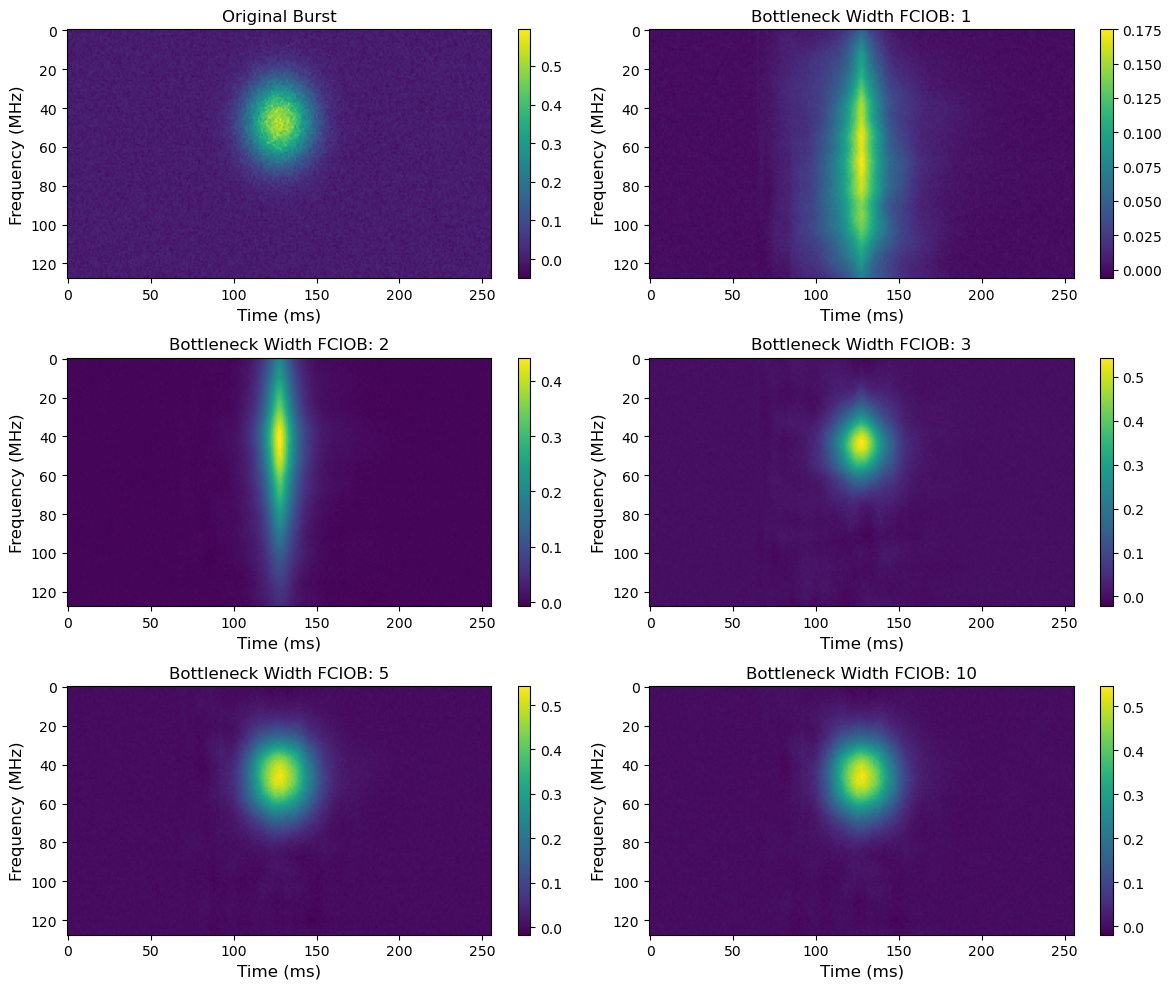

In [214]:
import random

# Select a random index to extract a burst for visualization
burst_idx = random.randint(0, len(data_test) - 1)

# Initialize a list to store the selected bottleneck widths
selected_widths = [1, 2, 3, 5, 10]  # Example: Selecting 5 bottleneck widths

# Retrieve the original burst for visualization
original_burst = data_test[burst_idx].squeeze()

# Create subplots for original and reconstructed bursts
plt.figure(figsize=(12, 10))

# Plot the original burst
plt.subplot(3, 2, 1)
plt.imshow(original_burst.T, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Original Burst")
plt.xlabel("Time (ms)", size=12)
plt.ylabel("Frequency (MHz)", size=12)

# Iterate over the selected bottleneck widths
for i, width in enumerate(selected_widths):
    # Select the reconstructed data for the current bottleneck width
    reconstructed = reconstructed_all[burst_idx, width - 1].reshape(original_burst.shape)

    # Plot the reconstructed burst
    plt.subplot(3, 2, i + 2)
    plt.imshow(reconstructed.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"Bottleneck Width FCIOB: {width}")
    plt.xlabel("Time (ms)", size=12)
    plt.ylabel("Frequency (MHz)", size=12)

plt.tight_layout()
plt.show()

